# Script C: Experiment 2

In [ ]:
library(osfr)
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'rstatix'

The following object is masked from 'package:stats':

    filter

here() starts at /Users/rp3650/Library/CloudStorage/GoogleDrive-robpetrosino@gmail.com/My Drive/Academics/projects/morphology/morphological-decomposition/sub-projects/frequency-effects/frequency-effect_masked-priming

## Power analysis

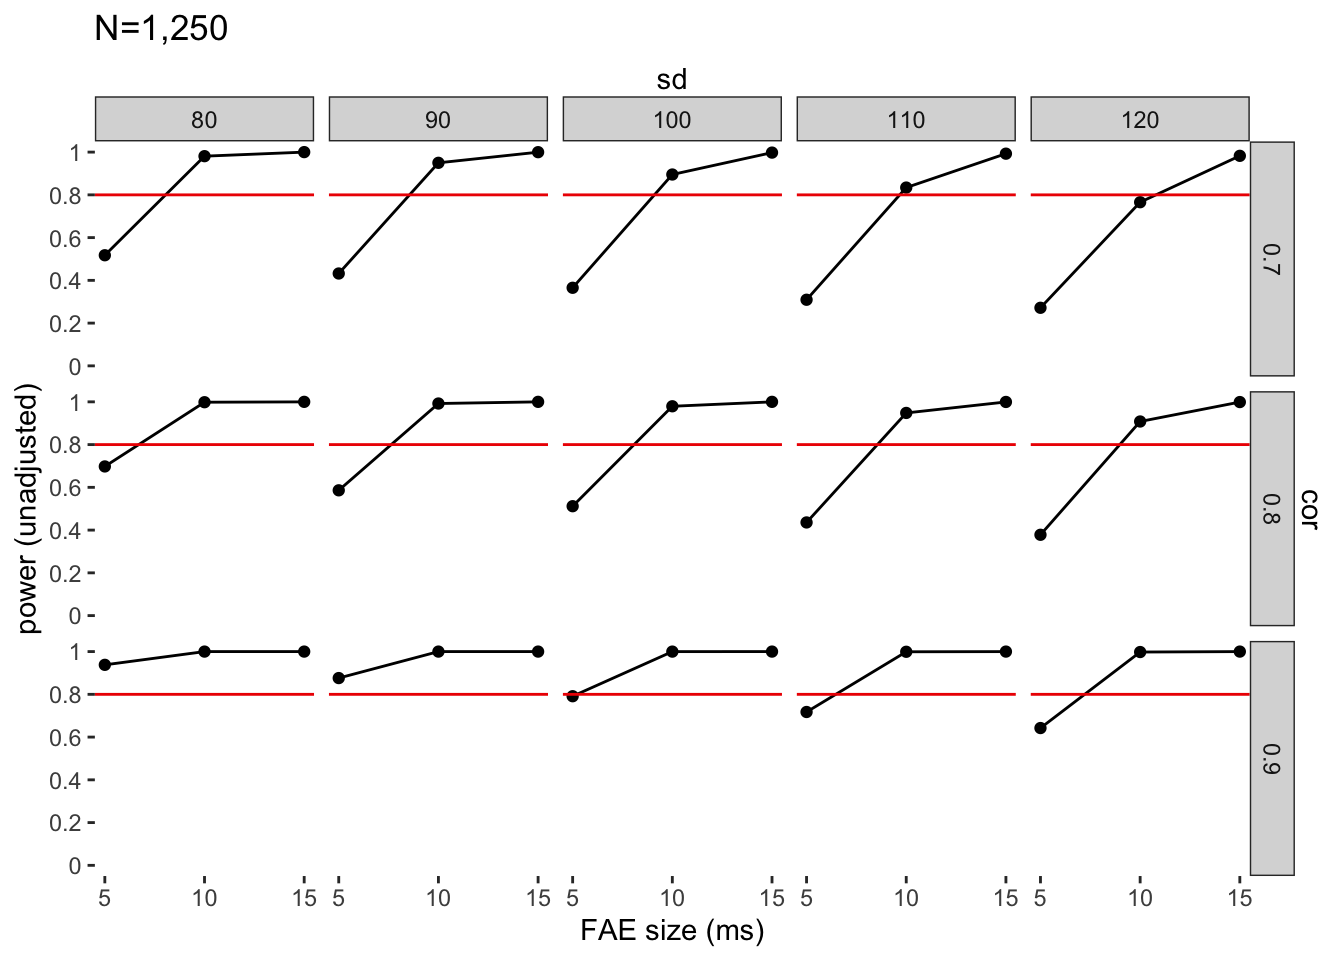

In [ ]:

load('../supplemental-data/freq_atten_exp2.5ms.RData') # ES = 5 ms
load('../supplemental-data/freq_atten_exp2.10ms.RData') # ES = 10 ms
load('../supplemental-data/freq_atten_exp2.15ms.RData') # ES = 15 ms

freq_atten_exp2.5ms_df.sub <- freq_atten_exp2.5ms_df %>% 
  filter(ES == 5) %>%
  filter(std_dev >= 80 & std_dev <= 120) %>%
  filter(rho >= 0.7 & rho <= 0.9)

freq_atten_exp2.10ms_df.sub <- freq_atten_exp2.10ms_df %>% 
  filter(ES == 10) %>%
  filter(std_dev >= 80 & std_dev <= 120) %>%
  filter(rho >= 0.7 & rho <= 0.9)

freq_atten_exp2.15ms_df.sub <- freq_atten_exp2.15ms_df %>% 
  filter(ES == 15 & grepl("interaction", row.names(freq_atten_exp2.15ms_df))) %>%
  filter(std_dev >= 80 & std_dev <= 120) %>%
  filter(rho >= 0.7 & rho <= 0.9)

power_pred_df <- bind_rows(freq_atten_exp2.5ms_df.sub, freq_atten_exp2.10ms_df.sub, freq_atten_exp2.15ms_df.sub) 

power_pred_df.sub1250 <- power_pred_df %>%
  filter(nsubj == 1250)

power_pred_df.sub1250 |>
  ggplot(aes(y = power_unadjusted, x = ES)) + 
    geom_line() + 
    geom_point() +
    geom_hline(yintercept = 0.8, color = "red2") + 
    facet_grid(rho ~ std_dev) +
  scale_x_continuous(breaks=seq(5, 15, 5), limits=c(5, 15), labels=seq(5, 15, 5),
    sec.axis = sec_axis(~ . , name = "sd", breaks = NULL, labels = NULL)) +
  scale_y_continuous(breaks=seq(0, 1, 0.2), limits=c(0, 1), labels=seq(0, 1, .2),
    sec.axis = sec_axis(~ . , name = "cor", breaks = NULL, labels = NULL)) +
  theme_bw()+
    theme(#axis.line = element_line(colour = "black"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(), 
      panel.border = element_blank(),
      legend.position="none"
      #panel.background = element_blank() 
     )+
  labs(title="N=1,250", y = "power (unadjusted)", x = "FAE size (ms)")


## Materials

In [ ]:
#|
words_exp2 <- read.csv('../materials/experiment2/frequency-effects_experiment2_stimuli.csv') %>% filter(type=='word')

needs_mutated <- function(x) {
  if(!is.numeric(x)) return(FALSE)
  max(x, na.rm = TRUE) > 100
}

words_exp2 %>%
  group_by(freq.bin) %>%
  mutate(Freq_HAL.Pm = (Freq_HAL * 10^6)/(131 * 10^6)) %>%
  summarise(N = n(),
            minFreq= min(Freq_HAL.Pm, na.rm = T), maxFreq=max(Freq_HAL.Pm, na.rm = T),
            meanFreq = mean(Freq_HAL.Pm, na.rm = T), sdFreq = sd(Freq_HAL.Pm, na.rm = T),
            minSUBFreq= min(SUBTLWF, na.rm = T), maxSUBFreq=max(SUBTLWF, na.rm = T),
            meanSUBFreq = mean(SUBTLWF, na.rm = T), sdSUBFreq = sd(SUBTLWF, na.rm = T),
            #meanRT=mean(as.numeric(I_Mean_RT), na.rm = T), sdRT=sd(as.numeric(I_Mean_RT), na.rm = T),
            #meanLength = mean(Length, na.rm = T), sdLength=sd(Length, na.rm = T)
            ) %>% 
  mutate_if(is.numeric, ~round(.)) %>% 
  mutate_if(needs_mutated, ~round(.)) %>%
  gt() %>%
  cols_label(
    freq.bin = "frequency", 
    minFreq = "min", maxFreq = "max", meanFreq = "mean", sdFreq = "SD", 
    minSUBFreq = "min", maxSUBFreq = "max", meanSUBFreq = "mean", sdSUBFreq = "SD") %>%
  tab_spanner(
    label=md("**HAL**"),
    columns=3:6
  ) %>%
  tab_spanner(
    label=md("**SUBTLEX~US~**"),
    columns=7:10
  )


## Data analysis

In [ ]:

# load the raw data dataframe
exp2_data_folder <- "experiment2"
exp2_rawdata_filename <- "experiment_2_preprocessed_data.csv"

## 02. check if the rawdata file exists. if not, download it from OSF.
if (!file.exists(here(exp2_data_folder, exp2_rawdata_filename))) {
  osf_retrieve_file("vn3r2") |> 
    osf_download(path = here(exp2_data_folder),
                 conflicts = "overwrite") 
}

## 03. read the data into R.
exp2_rawdata <- here(exp2_data_folder, exp2_rawdata_filename) |>
  read.csv(na = c("", "NA")) %>%
  mutate(primeTime = primeDuration - maskDuration) # calculating the actual SOA

exp2_info <- list()
exp2_info$intended_prime_duration <- 33
exp2_info$prime_dur_lb <- 25
exp2_info$prime_dur_ub <- 60
exp2_info$rt_lb <- 200
exp2_info$rt_ub <- 1800
exp2_info$freq_conditions <- c("high", "low", "non-word")
exp2_info$n_recruited <- exp2_rawdata$Rec_Session_Id |>
  unique() |>
  length()

exp2_rawdata.sub <- exp2_rawdata %>%
  filter(!is.na(TimeMeasure_Mean) & !is.na(primeDuration) & !is.na(responseError))
            
exp2_info$summary <- with(
  transform(exp2_rawdata.sub,
    RT_inrange = ifelse(RT >= exp2_info$rt_lb & RT <= exp2_info$rt_ub, 1, 0),
    Prime_inrange = ifelse((primeDuration - maskDuration) >= exp2_info$prime_dur_lb &
                             (primeDuration - maskDuration) <= exp2_info$prime_dur_ub, 1, 0)),
  {
    data.frame(aggregate(Start_Time ~ Rec_Session_Id + Crowdsourcing_SubjId, data=exp2_rawdata.sub, unique),
               aggregate(End_Time_Local ~ Rec_Session_Id + Crowdsourcing_SubjId, data=exp2_rawdata.sub, unique),
              aggregate(cbind(list, SelectedGender, SelectedAge, TimeMeasure_Mean, TimeMeasure_Std) ~ Rec_Session_Id + Crowdsourcing_SubjId, data=exp2_rawdata.sub, unique),
      aggregate(cbind(responseError, RT_inrange, Prime_inrange) ~ Rec_Session_Id + Crowdsourcing_SubjId, mean, data=exp2_rawdata.sub)
  )
}
)

exp2_info$summary <- exp2_info$summary[, -grep("Rec_Session_Id.|Crowdsourcing_SubjId.", colnames(exp2_info$summary))] # remove all extra aggregating columns (subj ID)

exp2_info$summary$Duration <- interval(ymd_hms(exp2_info$summary$Start_Time), 
                                             ymd_hms(exp2_info$summary$End_Time_Local)) |>
                                      lapply(function(interval_value) {interval_value/dminutes(1)}) |> 
                                           unlist()


### Step 1: subject and item performance

In [ ]:

exp2_step1_goodsubj <- exp2_info$summary |>
  subset(responseError <= .3) 

exp2_step1_subj_remain <- exp2_step1_goodsubj |> nrow()

exp2_step1_item.err <- exp2_rawdata.sub %>% group_by(condition_rec, target_rec) %>%
  summarise(word.percent=mean(responseError)*100) %>% 
  filter(word.percent > 30)


`summarise()` has grouped output by 'condition_rec'. You can override using the
`.groups` argument.

### Step 2: prime durations

In [ ]:

exp2_summary.primeTime <- exp2_rawdata.sub %>% 
  summarise(meanPrimeTime = round(mean(primeTime), 2), 
            sdPrimeTime = round(sd(primeTime), 2))

exp2_primeTimeRangeSummary <- exp2_rawdata.sub %>% 
  group_by(primeTime) %>%
  mutate(range = ifelse(primeTime < exp2_info$prime_dur_lb, "below", 
                        ifelse(primeTime > exp2_info$prime_dur_ub, "above",
                               "in range"))) %>% 
  group_by(range) %>% tally() %>% ungroup() %>%
  mutate(range.percent = round((n*100)/nrow(exp2_rawdata.sub),2))

exp2_data_step2 <- exp2_data_step1  |>
  subset(primeTime >= exp2_info$prime_dur_lb & primeTime <= exp2_info$prime_dur_ub)

exp2_step2_subj_remain <- exp2_data_step2$Rec_Session_Id |>
  unique() |>
  length()

exp2_step2_trials_remain <- nrow(exp2_data_step2)


### Step 3: RT distribution

In [ ]:

# RT outliers 
exp2_data_step3 <- exp2_data_step2 |> 
  subset(RT >= exp2_info$rt_lb & RT <= exp2_info$rt_ub)

exp2_step3_subj_remain <- exp2_data_step3$Rec_Session_Id |>
  unique() |>
  length()

exp2_step3_trials_remain <- nrow(exp2_data_step3)

# error trial removal

exp2_data_step3b <- exp2_data_step3  |>
  subset(responseError == 0)

exp2_step3b_subj_remain <- exp2_data_step3b$Rec_Session_Id |>
  unique() |>
  length()

exp2_step3b_trials_remain <- nrow(exp2_data_step3b)

# remove subjects with less than 12 trials in at least one condition*primetype combination (half of the total number of items per combination)
rt_data_labels <- c("Rec_Session_Id", "condition_rec", "primetype_rec", "RT")

exp2_subj_filter_2 <- exp2_data_step3b[, rt_data_labels] |>
  aggregate(RT ~ ., FUN = length, drop = FALSE) |>
  subset(RT < 7, select = Rec_Session_Id) |>
  unique() |>
  unlist()

### we also want to sure that all subjects have all conditions; in case some subject had all the trials for a given condition lost down the road, they will be removed
exp2_subj_filter_conditions <- 
  exp2_data_step3b %>%
  group_by(Rec_Session_Id) %>% 
  distinct(condition_rec, primetype_rec) %>% 
  tally() %>% filter(n != 6) %>% pull(Rec_Session_Id)

exp2_data_final <- exp2_data_step3b |>
  subset(!(Rec_Session_Id %in% exp2_subj_filter_2) & !(Rec_Session_Id %in% exp2_subj_filter_conditions))

exp2_final_subj_remain <- exp2_data_final$Rec_Session_Id |>
  unique() |> 
  length()
  
exp2_final_trials_remain <- nrow(exp2_data_final)


## Results

In [ ]:

# error rates averages
### we also want to sure that all subjects have all conditions; in case some subject had all the trials for a given condition lost down the road, they will be removed. Crucially the trial calculations are made on the dataset *before* the trial error removal step
exp2_subj_filter_2_with.errors <- exp2_data_step3[, rt_data_labels] |>
  aggregate(RT ~ ., FUN = length, drop = FALSE) |>
  subset(RT < 7, select = Rec_Session_Id) |>
  unique() |>
  unlist()
# this step just makes sure that the same subjects will be removed from both datasets
exp2_subj_filter_2_with.errors <- union(exp2_subj_filter_2_with.errors, exp2_subj_filter_2)

### just making sure that all subjects have all conditions; in case some subject had all the trials for a given condition lost down the road, they will be removed
exp2_subj_filter_conditions_with.errors <- 
  exp2_data_step3 %>%
  group_by(Rec_Session_Id) %>% 
  distinct(condition_rec, primetype_rec) %>% 
  tally() %>% filter(n != 6) %>% pull(Rec_Session_Id)

exp2_data_final_with.errors <- exp2_data_step3 |>
  subset(!(Rec_Session_Id %in% exp2_subj_filter_2_with.errors) & 
           !(Rec_Session_Id %in% exp2_subj_filter_conditions_with.errors)) 

exp2_error.rates <- exp2_data_final_with.errors %>%
  mutate(primetype_rec = factor(primetype_rec, levels=c("unrelated", "related")),
         condition_rec = factor(condition_rec, levels=c("high", "low", "non-word"))) %>%
  group_by(condition_rec, primetype_rec, Rec_Session_Id) %>%
  summarise(error.percent=mean(responseError)*100)


`summarise()` has grouped output by 'condition_rec', 'primetype_rec'. You can
override using the `.groups` argument.

`summarise()` has grouped output by 'Rec_Session_Id', 'condition_rec'. You can
override using the `.groups` argument.

`summarise()` has grouped output by 'Rec_Session_Id', 'condition_rec'. You can
override using the `.groups` argument.

`summarise()` has grouped output by 'condition_rec'. You can override using the
`.groups` argument.

ℹ In argument: `across(c(13), round, 2)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))

#### Stats summary

In [ ]:

exp2_summary.results_mop <- merge(exp2_gdavg_mop_summary, exp2_rt_stats_main, by='factor')
exp2_summary.results_fae <- merge(exp2_gdavg_fae_summary, exp2_rt_stats_interaction, by='factor') |>
  select(-mean_high, -mean_low)

exp2_summary.results <- bind_rows(exp2_summary.results_mop, exp2_summary.results_fae)
  
exp2_summary.results %>%
  relocate(c("sd_unrelated", "mean.error_unrelated"), .before=gd.mean_related) %>%
  gt() %>%
  cols_label(
    CI = "95% CI",
    contains("mean") ~ "mean",
    contains("sd") ~ "SD", 
    contains("error") ~ "Error (%)"
  ) %>%
  tab_spanner(
    label = "unrelated RT",
    columns = c(2:4)
  ) %>%
  tab_spanner(
    label = "repetition RT",
    columns = c(5:7)
  ) %>%
  tab_spanner(
    label = 'priming effects',
    columns = c(9:12)
  ) %>%
  tab_spanner(
    label = md("_t_-test"),
    columns = c(13:15)
  ) %>%
  cols_label(
    sd = md("SD~p~")
  ) %>%
  cols_label(
    t = md("_t_"),
    p = md("_p_"),
  ) %>%
   sub_missing(
    missing_text = " "
  )
